# BPRS-E attempt at factor analysis

In this notebook, I was looking whether we should do a factor analysis on the BPRS-E.  In the end, the results are non-converging, so we decided not to go with this strategy.

In [1]:
from __future__ import division

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import cross_val_score
from utils.prog import log_progress as lp
import statsmodels.formula.api as smf
from numpy import transpose as T
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from utils import neuropsych
import scipy.stats as stats
import matplotlib as mpl
import sklearn.cluster
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import palettable
import warnings
import scipy
import time
import sys
import os

%matplotlib inline
%load_ext rpy2.ipython

#cols = palettable.colorbrewer.qualitative.Dark2_8.hex_colors
cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

#warnings.filterwarnings("ignore")
CONDIR = os.environ.get("CONDIR")

In [2]:
table = "TRAINTABLE"
RC = pd.read_csv(os.environ.get(table),low_memory=False)

In [3]:
subsets = {}

### Subset BPRS-E

There is no composite score or factor analysis available.  When verifying if there is a clear factor structure, different methods point in different directions, ranging of suggested factors between 2 and 22 factors.  This suggests that our solution might be suboptimal.  Therefore it makes sense to sum together the items rather than looking for factors.

In [13]:
subsets['BPRS-E']=[
    'somatic_concerns',
    'anxiety',
    'depression',
    'guilt',
    'hostility',
    'suspiciousness',
    'unusual_thought_content',
    'grandiosity',
    'hallucinations',
    'disorientation',
    'conceptual_disorganization',
    'excitement',
    'motor_retardation',
    'blunted_affect',
    'tension',
    'mannerisms_and_posturing',
    'uncooperativeness',
    'emotional_withdrawal',
    'suicidality',
    'self_neglect',
    'bizarre_behaviors',
    'elevated_mood',
    'motor_hyperactivity',
    'distractability'
]

In [14]:
subtab = RC[subsets['BPRS-E']]
cor = np.array(subtab.corr())

This looks like it's a multidimensional scale.  Let's see what factor analysis suggests...

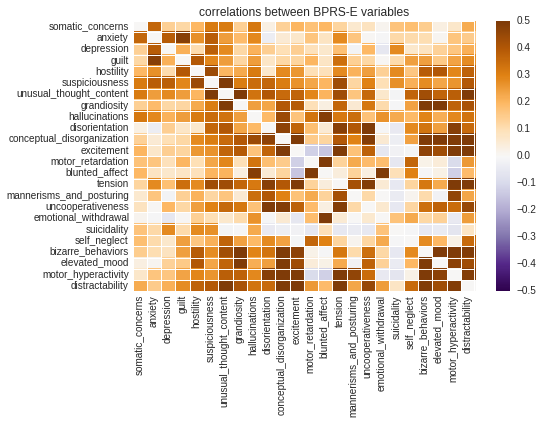

In [15]:
np.fill_diagonal(cor,0)
correlation_plot(cor = cor,
                 labels = subsets['BPRS-E'],
                 colrange = [-0.5,0.5],
                 gridcolor='white',
                 title='correlations between BPRS-E variables')

In [85]:
subtab = subtab.fillna(0)

Parallel analysis suggests that the number of factors =  5  and the number of components =  4 


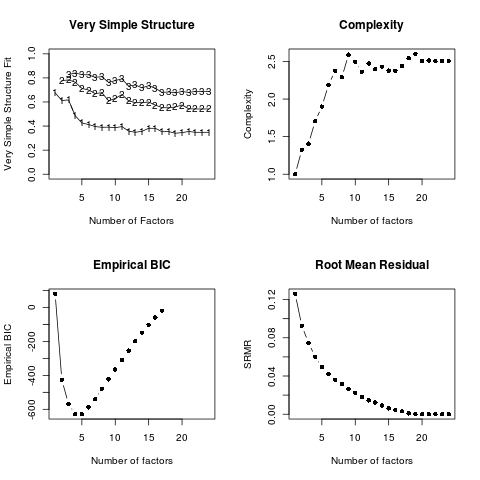

In [91]:
%%R -i subtab -o factortable

maxfac <- min(dim(subtab)[2],50)

library(psych)
factortable <- nfactors(subtab,n=maxfac,rotation='varimax')$vss.stats
factortable['eigen'] <- eigen(cor(subtab))$values[1:maxfac]

parallel <- fa.parallel(subtab,plot=FALSE)
factortable['parallel_data'] <- parallel$fa.values[1:maxfac]
factortable['parallel_sim'] <- parallel$fa.sim[1:maxfac]

vss <- vss(subtab,n=maxfac,rotate='varimax',plot=FALSE)
factortable['map'] <- vss$map

In [93]:
subtab = subtab.fillna(0)
n_components = np.arange(1,10)
fa_mean_scores, fa_std_scores, maxlog = factor_ncomponents(
    subtab,n_components,cvgroups=len(subtab))


Hmm, looks like a factor analysis is not appropriate since the results are so diverging.  We can work with the average, as subscales (genre depression, negative symptoms, positive symptoms) are covered by the (published) factors in LDPS.

In [97]:
from utils import factanal

minfact = factanal.evaluate_factors(factortable)
cvmin = n_components[np.min(np.where(max(fa_mean_scores)==fa_mean_scores))]
print("Based on leave-1-out CV, the minimum number of factors is %i"%int(cvmin))

Based on the likelihood ration test, Model(N)-Model(0), the minimum number of factors is 16
Based on the likelihood ration test, Model(b)-Model(n-1), the minimum number of factors is 20
Based on the RMSEA, the minimum number of factors is 17
Based on the kaiser criterion, the minimum number of factors is 7
Based on the BIC, the minimum number of factors is 17
Based on the empirical BIC, the minimum number of factors is 3
Based on the complexity, the minimum number of factors is 18
Based on the standardised root mean square residual, the minimum number of factors is 22
Based on parallel analysis, the minimum number of factors is 5
Based on the minimum average partial correlation method, the minimum number of factors is 2
Based on leave-1-out CV, the minimum number of factors is 3
